In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp
import matplotlib
import matplotlib.pyplot as plt
from datetime import date
import copy


from functions import simulate_counts, plotsigs, cosine_HA
from AAUtoSig_init import get_lr, train_AAUtoSig

In [11]:
class AAUtoSig(torch.nn.Module):
    def __init__(self, feature_dim, latent_dim, tied = False):
    
        super().__init__()
        # Building an linear encoder
        # 96 => dim1 => dim2
        self.tied = tied
        self.enc1 = torch.nn.Linear(feature_dim, latent_dim, bias = False)
        self.dec1 = torch.nn.Linear(latent_dim, feature_dim, bias = False) if not tied else None
          
    def forward(self, x):
        x = self.enc1(x)
        x = self.dec1(x) if not self.tied else F.linear(x, self.enc1.weight.data.t())
        #x = F.relu(self.dec1(x))
        return x

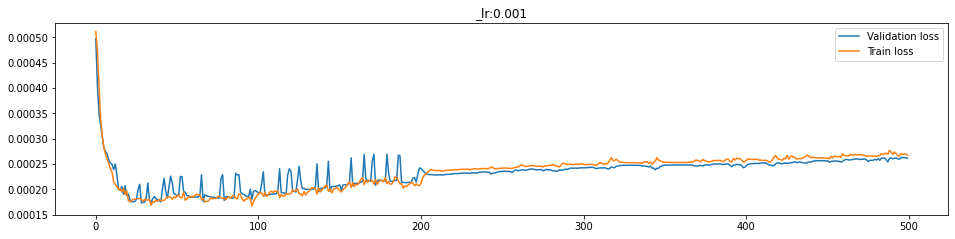

<Figure size 432x288 with 0 Axes>

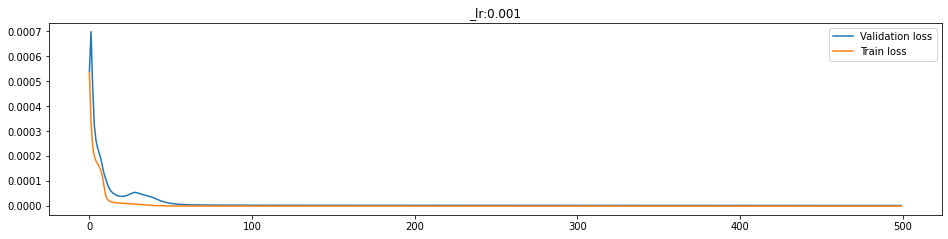

<Figure size 432x288 with 0 Axes>

In [12]:
nsigs = 5

#np.random.seed(20)
#random.seed(20)
mf_df, true_sigs,_ = simulate_counts(nsigs, 3000, pentanucelotide=False)
tri = mf_df.index
mutation = [t[2:5] for t in tri]

#X = (mf_df / mf_df.sum(axis=0)).T
X = mf_df.T/mf_df.max().max()


#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model_tied = AAUtoSig(96, nsigs, tied = True)
model_free = AAUtoSig(96, nsigs)


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer_tied = torch.optim.Adam(model_tied.parameters(),
                            lr = 1e-3)
optimizer_free = torch.optim.Adam(model_free.parameters(),
                            lr = 1e-3)

#---------------- TIED ----------------------                            
_,val_loss_tied, train_loss_tied = train_AAUtoSig(epochs = 500, 
                                        model = model_tied, 
                                        x_train = x_train,
                                        x_test = x_val, 
                                        criterion = loss_function, 
                                        optimizer = optimizer_tied,
                                        batch_size = 16,
                                        do_plot = True, 
                                        ES = False, 
                                        i = None, 
                                        non_negative = "all")




#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_tied = model_tied.enc1.weight.data.T
exp_tied = pd.DataFrame(x_train@model_tied.enc1.weight.data.T)
#exp_all['index'] = exp_all.index
#exp_all.plot(x = 'index', kind = 'bar', stacked = 'False', title = "Exposure values, all non negative")
sigs_tied = pd.DataFrame(sigs_tied.numpy()) 


#---------------- FREE ----------------------                            
_,val_loss_free, train_loss_free = train_AAUtoSig(epochs = 500, 
                                        model = model_free, 
                                        x_train = x_train,
                                        x_test = x_val, 
                                        criterion = loss_function, 
                                        optimizer = optimizer_free,
                                        batch_size = 16,
                                        do_plot = True, 
                                        ES = False, 
                                        i = None, 
                                        non_negative = "all")




#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_free = model_free.dec1.weight.data
exp_free = pd.DataFrame(x_train@model_free.enc1.weight.data.T)
#exp_all['index'] = exp_all.index
#exp_all.plot(x = 'index', kind = 'bar', stacked = 'False', title = "Exposure values, all non negative")
sigs_free = pd.DataFrame(sigs_free.numpy()) 


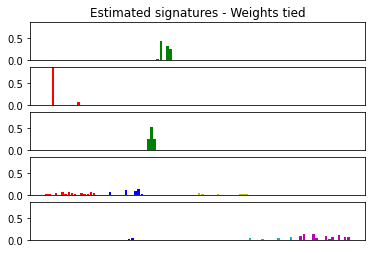

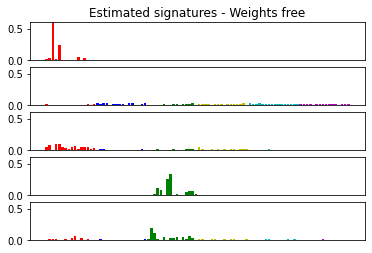

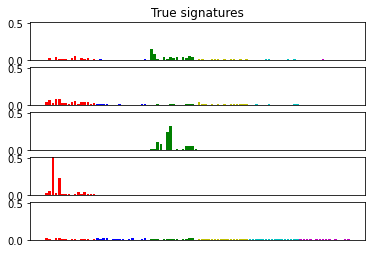

          0         1         2         3         4
0  0.338095  0.000733  0.000694  0.000096  0.000176
1  0.000733  0.732005  0.001992  0.000239  0.000951
2  0.000694  0.001992  0.378348  0.001004  0.000142
3  0.000096  0.000239  0.001004  0.060329  0.000345
4  0.000176  0.000951  0.000142  0.000345  0.078841
          0         1         2         3         4
0  0.422154  0.002149  0.026875  0.001593  0.005046
1  0.002149  0.016744  0.005604  0.005109  0.007649
2  0.026875  0.005604  0.045798  0.003240  0.012273
3  0.001593  0.005109  0.003240  0.203904  0.018606
4  0.005046  0.007649  0.012273  0.018606  0.070394


In [14]:
#plot the results
plotsigs(tri, sigs_tied.to_numpy(), nsigs, "Estimated signatures - Weights tied")
plotsigs(tri, sigs_free.to_numpy(), nsigs, "Estimated signatures - Weights free")    
plotsigs(tri, true_sigs.to_numpy(), nsigs, "True signatures") 
 
print(sigs_tied.T@sigs_tied)
print(sigs_free.T@sigs_free)
